In [1]:
from __future__ import print_function

import numpy as np
import random

from matplotlib import pyplot as plt

from selectinf.nbd_lasso import nbd_lasso
from selectinf.Utils.discrete_family import discrete_family
from statsmodels.distributions.empirical_distribution import ECDF
from instance import GGM_instance

from nbd_naive_and_ds import *
from scipy.integrate import quad
from scipy.optimize import root_scalar

In [9]:
# TODO: Add root n to the randomization covariance
# Remark: Not needed (?) anymore since X is now scaled
prec,cov,X = GGM_instance(n=200,p=20, max_edges=1)
nbd_instance = nbd_lasso.gaussian(X, n_scaled=False)
active_signs_nonrandom = nbd_instance.fit(perturb=np.zeros((20,19)))
active_signs_random = nbd_instance.fit()
print(active_signs_nonrandom.shape)
print(np.abs(active_signs_nonrandom).sum())
print(np.abs(active_signs_random).sum())
print(np.abs(prec != 0).sum() - 10)

(20, 19)
4.0
4.0
14


In [10]:
true_non0 = (prec!=0)
for j in range(prec.shape[0]):
    true_non0[j,j] = False
nonzero, intervals, cov_rate, avg_len = naive_inference(X, prec, true_nonzero=true_non0)
print(cov_rate)

True nonzero used
0.5


/Users/yilingh/Desktop/PhD/SI_Codes/SI-Graphs/selectinf/Utils/discrete_family.py:146: RuntimeWarning: overflow encountered in exp
  self._partition *= np.exp(_largest)


In [11]:
def print_nonzero_intervals(nonzero, intervals, prec, X):
    # Intervals, prec, X are all in their original scale
    n, p = X.shape
    S = X.T @ X / n

    for i in range(p):
            for j in range(i+1,p):
                if nonzero[i,j]:
                    print("(",i,",",j,")", "selected")
                    print("Theta", "(",i,",",j,")", "interval:", intervals[i,j,:])
                    print("Theta", "(",i,",",j,")", prec[i,j])
                    print("S/n", "(",i,",",j,")", S[i,j])
print_nonzero_intervals(nonzero, intervals, prec, X)

( 5 , 12 ) selected
Theta ( 5 , 12 ) interval: [0.52692951 0.82063092]
Theta ( 5 , 12 ) 0.715513279632411
S/n ( 5 , 12 ) -1.2340544017946828
( 8 , 18 ) selected
Theta ( 8 , 18 ) interval: [0.9590312  1.39457533]
Theta ( 8 , 18 ) 0.7860938387279081
S/n ( 8 , 18 ) -2.5446153157614693


In [12]:
#nonzero = get_nonzero(active_signs_nonrandom)
p=10
n=500
for i in range(p):
    for j in range(i+1,p):
        if nonzero[i,j]:
            print("(i,j) = (",i,",",j,")")
            print("Theta", prec[i,j])

In [13]:
p=10
n=500
S=X.T @ X/n
theta_hat = np.linalg.inv(S)
pivot, lcb, ucb = edge_inference_scipy(j0=5,k0=7,S=S,n=n,p=p,Theta_hat=theta_hat,ngrid=10000)
print(lcb/n, ucb/n)

/Users/yilingh/Desktop/PhD/SI_Codes/SI-Graphs/selectinf/Tests/nbd_naive_and_ds.py:195: RuntimeWarning: divide by zero encountered in log
  cdf_upper = np.exp(np.log(quad(condl_pdf_normalized, inner_prod, grid_ub,


-0.005781239256987874 0.00011780859457459092


In [17]:
print(np.diag(S))

[1.09859146 1.06775419 1.19826373 1.07099661 1.14623754 1.16075903
 1.0522284  0.92166946 1.00847615 1.04040878]


In [7]:
intervals = conditional_inference(X/np.sqrt(n), true_non0)

t_j_k (center of root finding) -80.66748017291589
theta_hat -0.16133496034583178
( 0 , 1 ): ( -0.23006612527808273 , -0.08847419488867843 )
t_j_k (center of root finding) 100.62697505694439
theta_hat 0.20125395011388877
( 0 , 5 ): ( 0.128588878626462 , 0.2987750167795382 )
t_j_k (center of root finding) -59.12579124805222
theta_hat -0.11825158249610443
( 1 , 3 ): ( -0.23670532356971286 , -0.06450845848792573 )
t_j_k (center of root finding) -108.96408991567854
theta_hat -0.2179281798313571
( 3 , 9 ): ( -0.3668014613102389 , -0.2619785395573092 )
t_j_k (center of root finding) -88.43274612000404
theta_hat -0.17686549224000808
( 5 , 7 ): ( -0.2108598331366145 , -0.06430259741884108 )
t_j_k (center of root finding) -113.39353407969124
theta_hat -0.22678706815938246
( 8 , 9 ): ( -0.10844996145467053 , -0.10254147222737563 )


In [8]:
n,p = X.shape

S=X.T @ X/n
theta_hat = np.linalg.inv(S)
# Estimating variances by bootstrap
# inner_vars = bootstrap_variance(X)

#S_ = (X.T @ X) / n
#theta_h = np.linalg.inv(S_)
intervals = np.zeros((p,p,2))
# condlDists = {}
for i in range(p):
    for j in range(i+1,p):
        if nonzero[i,j]:
            print(S)
            """# neg_int are intervals for n * theta
            neg_int, condlWishart = edge_inference(j0=i, k0=j, S=S_,
                                                   # var=inner_vars[i, j],
                                                   n=n, p=p, ngrid=50000)"""
            pivot, lcb, ucb = edge_inference_scipy(j0=i, k0=j, S=S,
                                                   n=n, p=p, Theta_hat=theta_hat)
            # interval = invert_interval(neg_int, scalar=n)
            intervals[i,j,0] = lcb/n
            intervals[i,j,1] = ucb/n
            print("(", i, ",", j, "): (", lcb/n, ",", ucb/n, ")")
            if ucb/n - lcb/n < 0.01:
                print("WARNING: SHORT INTERVAL")

[[ 1.18999389e+00  1.99714249e-01  2.03606071e-02 -8.35228828e-03
   5.34819999e-02 -2.22785874e-01 -2.49132680e-02 -4.30205495e-02
  -8.25042850e-03  4.80001580e-03]
 [ 1.99714249e-01  1.06058983e+00 -7.35904073e-02  1.03391280e-01
   3.25089013e-02 -7.83883015e-02 -2.10093303e-02  6.76489551e-02
  -9.53730086e-03 -5.36029911e-02]
 [ 2.03606071e-02 -7.35904073e-02  1.01576286e+00 -5.44000771e-02
  -1.40209317e-02  1.11038273e-02  2.26094989e-02 -1.64759759e-02
  -4.87192509e-02 -5.98587193e-04]
 [-8.35228828e-03  1.03391280e-01 -5.44000771e-02  1.00364101e+00
   2.22710206e-02 -4.43959755e-02 -1.01392447e-02 -6.61393808e-03
   1.03259258e-01  2.13204571e-01]
 [ 5.34819999e-02  3.25089013e-02 -1.40209317e-02  2.22710206e-02
   1.00928287e+00 -6.73358404e-03  8.88218540e-02 -1.07524587e-02
   5.59117129e-02  8.28248100e-02]
 [-2.22785874e-01 -7.83883015e-02  1.11038273e-02 -4.43959755e-02
  -6.73358404e-03  9.54014084e-01  1.13460526e-02  1.70100096e-01
  -1.41550786e-01 -5.53743105e-02

In [6]:
def edge_inference_scipy_test(j0, k0, S, n, p, Theta_hat=None, var=None, level=0.9, ngrid=10000):
    # n_total: the total data points in data splitting
    #        : the raw dimension of X in naive
    inner_prod = S[j0,k0]

    # Theta_hat: A low dimensional point estimate of theta
    if Theta_hat is None:
        t_j_k = - inner_prod * n
    else:
        t_j_k = Theta_hat[j0,k0] * n

    print("t_j_k (center of root finding)", t_j_k)
    print("theta_hat", Theta_hat[j0,k0])

    S_copy = S

    def log_det_S_j_k(s_val):
        S_j_k = S_copy
        S_j_k[j0,k0] = s_val
        S_j_k[k0,j0] = s_val
        return np.log(np.abs(np.linalg.det(S_j_k))) * (n-p-1)/2
    def det_S_j_k(s_val):
        return np.exp(log_det_S_j_k(s_val))

    """def get_logdet_normalizer():
        sparse_grid = np.linspace(-2, 2, num=100)
        sparse_log_det = np.zeros((ngrid,))
        for g in range(100):
            sparse_log_det[g] = log_det_S_j_k(sparse_grid[g])
        log_det_normalizer = np.max(sparse_log_det)
        return log_det_normalizer

    ldn = get_logdet_normalizer()
    print("ldn", np.exp(ldn))
    # normalized determinant by multiplying 1/det_S_j_k(0)

    def det_S_j_k_nomalized(s_val, log_normalizer=0):
        return np.exp(log_det_S_j_k(s_val) - np.log(det_S_j_k(0)))"""

    def condl_pdf(t,theta=0):
        return det_S_j_k(t) * np.exp(-theta*t)

    def condl_log_pdf(t,theta=0):
        return log_det_S_j_k(t) - theta * t

    def get_pivot(theta0=0, plot=False):
        # print("new run")
        # Normalize the pdf by the maximum over a sparse grid
        def get_pdf_log_normalizer(theta0):
            sparse_grid = np.linspace(-1, 1, num=100)
            sparse_lpdf = np.zeros((100,))
            for g in range(100):
                sparse_lpdf[g] = condl_log_pdf(sparse_grid[g],theta0)
            pdf_log_normalizer = np.max(sparse_lpdf)# - 5

            """# for test uses
            stat_grid = np.linspace(-1, 1, num=ngrid)
            density = np.zeros((ngrid,))
            for g in range(ngrid):
                density[g] = np.exp(condl_log_pdf(stat_grid[g],theta0) - pdf_log_normalizer)
            print("pdfln:", pdf_log_normalizer)
            print("normalized pdf mode",np.max(density))

            if pdf_log_normalizer == 0.0:
                plt.plot(sparse_grid, sparse_lpdf)"""

            """if pdf_log_normalizer > 100:
                pdf_log_normalizer -= 100"""
            return pdf_log_normalizer

        pdfln = get_pdf_log_normalizer(theta0)
        #print("pdfln", pdfln)
        # Normalized pdf
        def condl_pdf_normalized(t, theta=0):
            return np.exp(log_det_S_j_k(t) - theta*t - pdfln)

        grid_lb = -1
        grid_ub = 1
        normalizer = quad(condl_pdf_normalized,
                          grid_lb,
                          grid_ub, args=(theta0,))[0]
        #print("normalizer", normalizer)
        #print("normalizer == 0", normalizer == 0)
        #print("log normalizer:", np.log(normalizer))
        cdf_upper = np.exp(np.log(quad(condl_pdf_normalized, inner_prod, grid_ub,
                         args=(theta0,))[0]) - np.log(normalizer))

        if plot:
            stat_grid = np.zeros((1, ngrid))

            stat_grid[0, :] = np.linspace(grid_lb,
                                          grid_ub,
                                          num=ngrid)
            density = np.zeros((ngrid,))
            for g in range(ngrid):
                density[g] = condl_pdf_normalized(stat_grid[0, g], theta0)

            # print("Max normalized pdf:", np.max(density))
            plt.plot(stat_grid[0, :], density)
        return cdf_upper

    pivot = get_pivot(0)

    def get_pivot_val(x,val=0.99):
        return get_pivot(x) - val

    # print("bracket", t_j_k - 0.2 * n, t_j_k + 0.2 * n)

    # Construct CI
    margin = (1 - level) / 2
    """root_low = root_scalar(get_pivot_val, bracket=[t_j_k - 0.05 * n, t_j_k + 0.15 * n], args=(margin,),
                           method='bisect')
    root_up = root_scalar(get_pivot_val, bracket=[t_j_k - 0.15 * n, t_j_k + 0.05 * n], args=(1 - margin,),
                          method='bisect')

    return pivot, root_up.root, root_low.root"""
    root_low = find_root(f=get_pivot, y=margin, lb=t_j_k - 0.2 * n, ub=t_j_k + 0.4 * n, tol=1e-4)
    root_up = find_root(f=get_pivot, y=1 - margin, lb=t_j_k - 0.4 * n, ub=t_j_k + 0.2 * n, tol=1e-4)

    pvtlow = get_pivot(t_j_k - 0.4 * n, plot=True)
    pvtup = get_pivot(t_j_k + 0.4 * n, plot=True)
    F_low = get_pivot(root_low)
    F_up = get_pivot(root_up)
    #print("p-value at lower root:", F_low)
    #print("p-value at upper root:", F_up)

    return pivot, root_up, root_low

t_j_k (center of root finding) -113.39353407969126
theta_hat -0.22678706815938252
-0.3011046665022781 -0.14661495855550072


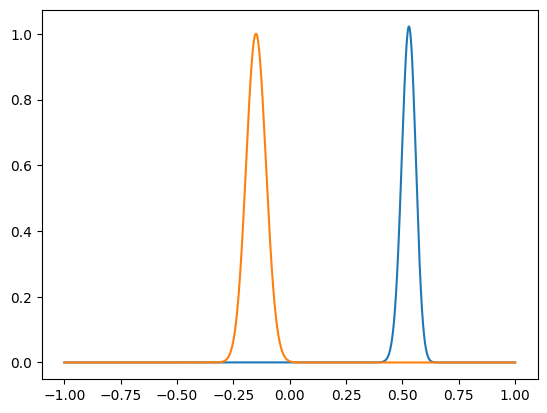

In [22]:
S_ = (X.T @ X) / n
thetah = np.linalg.inv(S_)
pivot, lcb, ucb = edge_inference_scipy_test(j0=8, k0=9, S=S_, n=n, p=p,
                                            Theta_hat=thetah)
print(lcb/n, ucb/n)

In [15]:
print(S == S_)

[[ True False  True  True  True False  True  True  True  True]
 [False  True  True False  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True False  True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True]
 [False  True  True  True  True  True False False  True  True]
 [ True  True  True  True  True False  True  True  True  True]
 [ True  True  True  True  True False  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True False]
 [ True  True  True False  True  True  True  True False  True]]


In [16]:
print(true_non0)

[[False  True False False False  True False False False False]
 [ True False False  True False False False False False False]
 [False False False False False False False False False False]
 [False  True False False False False False False False  True]
 [False False False False False False False False False False]
 [ True False False False False False False  True False False]
 [False False False False False False False False False False]
 [False False False False False  True False False False False]
 [False False False False False False False False False  True]
 [False False False  True False False False False  True False]]


t_j_k (center of root finding) 74.22304190358531
theta_hat 0.14844608380717061
0.0706165797941091 0.22248902394694117


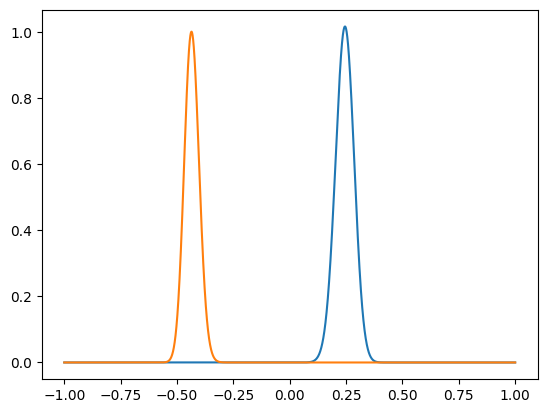

In [135]:
S_new = (X.T @ X) / n
thetah = np.linalg.inv(S_new)
pivot, lcb, ucb = edge_inference_scipy_test(j0=3, k0=9, S=S_new, n=n, p=p,
                                            Theta_hat=thetah)
print(lcb/n, ucb/n)

In [11]:
def evaluate_pivot(iter=500):
    pvals = []
    for i in range(iter):
        prec,cov,X = GGM_instance(n=1000,p=10, max_edges=2)
        S=X.T @ X/n
        theta_hat = np.linalg.inv(S)
        pivot, lcb, ucb = edge_inference_scipy(j0=6,k0=8,S=X.T @ X/n,n=n,p=p,Theta_hat=theta_hat, prec=prec)
        pvals.append(pivot)

    plt.clf()
    ecdf_pivot = ECDF(np.asarray(pvals))
    grid = np.linspace(0, 1, iter)
    plt.plot(grid, ecdf_pivot(grid), c='blue', marker='^')
    plt.plot(grid, grid, 'k--')
    plt.show()

In [80]:
evaluate_pivot()

TypeError: edge_inference_scipy() got an unexpected keyword argument 'prec'

In [ ]:
lcb, ucb

In [ ]:
int(1>0)

In [34]:
j0=1
k0=5
S=X.T @ X/n
theta_hat = np.linalg.inv(S)
t_j_k = theta_hat[j0,k0] * n
ngrid=10000
# n_total: the total data points in data splitting
#        : the raw dimension of X in naive
inner_prod = S[j0,k0]

print(inner_prod)

def log_det_S_j_k(s_val):
    S_j_k = S
    S_j_k[j0,k0] = s_val
    S_j_k[k0,j0] = s_val
    return np.log(np.abs(np.linalg.det(S_j_k))) * (n-p-1)/2
def det_S_j_k(s_val):
    return np.exp(log_det_S_j_k(s_val))

"""def get_logdet_normalizer():
    sparse_grid = np.linspace(-2, 2, num=100)
    sparse_log_det = np.zeros((ngrid,))
    for g in range(100):
        sparse_log_det[g] = log_det_S_j_k(sparse_grid[g])
    log_det_normalizer = np.max(sparse_log_det)
    return log_det_normalizer

ldn = get_logdet_normalizer()
print("ldn", np.exp(ldn))
# normalized determinant by multiplying 1/det_S_j_k(0)

def det_S_j_k_nomalized(s_val, log_normalizer=0):
    return np.exp(log_det_S_j_k(s_val) - np.log(det_S_j_k(0)))"""

def condl_pdf(t,theta=0):
    return det_S_j_k(t) * np.exp(-theta*t)

def condl_log_pdf(t,theta=0):
    return log_det_S_j_k(t) - theta * t

def get_pivot(theta0=0):
    # Normalize the pdf by the maximum over a sparse grid
    def get_pdf_log_normalizer(theta0):
        sparse_grid = np.linspace(-2, 2, num=100)
        sparse_lpdf = np.zeros((ngrid,))
        for g in range(100):
            sparse_lpdf[g] = condl_log_pdf(sparse_grid[g],theta0)
        pdf_log_normalizer = np.max(sparse_lpdf)

        if pdf_log_normalizer > 100:
            pdf_log_normalizer /= 10
        return pdf_log_normalizer

    pdfln = get_pdf_log_normalizer(theta0)
    print("pdfln", pdfln)
    # Normalized pdf
    def condl_pdf_normalized(t, theta=0):
        return det_S_j_k(t) * np.exp(-theta*t - pdfln)

    grid_lb = -1
    grid_ub = 1
    normalizer = quad(condl_pdf_normalized,
                      grid_lb,
                      grid_ub, args=(theta0,))[0]

    cdf_upper = quad(condl_pdf_normalized, inner_prod, grid_ub,
                     args=(theta0,))[0] / normalizer

    stat_grid = np.zeros((1, ngrid))

    stat_grid[0,:] = np.linspace(grid_lb,
                                 grid_ub,
                                 num=ngrid)
    density = np.zeros((ngrid,))
    logdet = np.zeros((ngrid,))
    for g in range(ngrid):
        density[g] = condl_pdf_normalized(stat_grid[0,g], theta0)
        logdet[g] = det_S_j_k(stat_grid[0,g])

    plt.plot(stat_grid[0,:], density)
    plt.figure(2)
    plt.plot(stat_grid[0,:], logdet)
    return cdf_upper

-0.034277203964113476


In [ ]:
def get_pivot_val(x,val=0.99):
    return get_pivot(x) - val

In [ ]:
root_up = root_scalar(get_pivot_val, bracket=[t_j_k-300,t_j_k+300], args=(0.95,),
                           method='bisect')

In [ ]:
root_low = root_scalar(get_pivot_val, bracket=[t_j_k-300,t_j_k+300], args=(0.05,),
                           method='bisect')

In [ ]:
root_up, root_low

In [ ]:
get_pivot(300)# - 0.95

In [ ]:
root_up.root

In [ ]:
get_pivot_val(-1000,0.05)

In [ ]:
get_pivot_val(2,0.95)

In [13]:
X = np.zeros((2,5))
Y = np.copy(X)
X[1,3] = 1

In [14]:
print(Y)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
